# Financial Sentiment Analysis - Complete Pipeline Report

This notebook runs the complete ML pipeline:
1. Data loading and preprocessing
2. Model training
3. Model evaluation
4. Label quality analysis
5. Results visualization

**Results are saved to:** `results/` directory


In [1]:
# Setup
import sys
import os

# Get project root directory
# If running from notebooks/, go up one level; otherwise use current directory
current_dir = os.getcwd()
if os.path.basename(current_dir) == 'notebooks':
    PROJECT_ROOT = os.path.dirname(current_dir)
    os.chdir(PROJECT_ROOT)  # Change to project root
else:
    PROJECT_ROOT = current_dir

# Add src to path
src_path = os.path.join(PROJECT_ROOT, 'src')
if src_path not in sys.path:
    sys.path.insert(0, src_path)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

from dataset_loader import load_dataset
from preprocess import preprocess_batch
from model import build_model, get_all_top_features
from label_quality import detect_misclassifications, detect_ambiguous_predictions, detect_noisy_labels

%matplotlib inline
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configuration - paths relative to project root
DATA_PATH = os.path.join(PROJECT_ROOT, 'data', 'SEntFiN.csv')  # Change this to your dataset
DATASET_NAME = 'sentfin'  # 'phrasebank', 'semeval', or 'sentfin'
TEST_SIZE = 0.2
RANDOM_STATE = 42
MAX_FEATURES = 10000
RESULTS_DIR = os.path.join(PROJECT_ROOT, 'results')
MODEL_PATH = os.path.join(RESULTS_DIR, 'model.joblib')

# Verify paths
print("✓ Setup complete!")
print(f"  Project root: {PROJECT_ROOT}")
print(f"  Current directory: {os.getcwd()}")
print(f"  Dataset path: {DATA_PATH}")
print(f"  Dataset exists: {os.path.exists(DATA_PATH)}")
print(f"  Results directory: {RESULTS_DIR}")


✓ Setup complete!
  Project root: /Users/algernon/5100Project/financial-sentiment-project
  Current directory: /Users/algernon/5100Project/financial-sentiment-project
  Dataset path: /Users/algernon/5100Project/financial-sentiment-project/data/SEntFiN.csv
  Dataset exists: True
  Results directory: /Users/algernon/5100Project/financial-sentiment-project/results


## 1. Load and Explore Data


Loading dataset...
✓ Loaded 10753 samples

Dataset Info:
  Shape: (10753, 2)
  Columns: ['text', 'label']

Label Distribution:
label
positive    4112
neutral     3517
negative    3124
Name: count, dtype: int64

Label Proportions:
label
positive    0.382405
neutral     0.327072
negative    0.290524
Name: count, dtype: float64


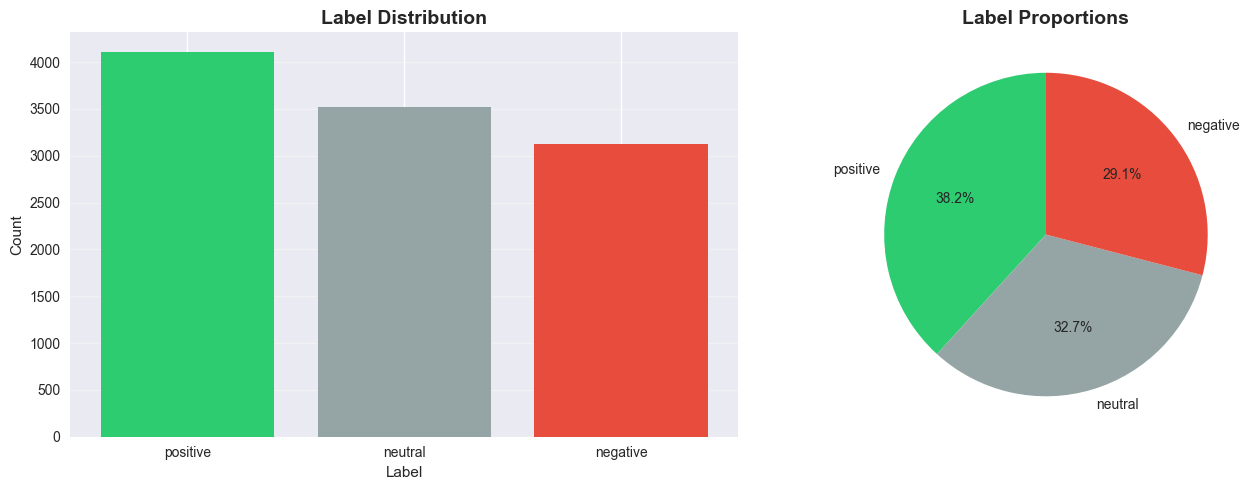


Sample Texts by Label:

NEUTRAL:
  1. SpiceJet to issue 6.4 crore warrants to promoters...
  2. MMTC Q2 net loss at Rs 10.4 crore...
  3. Market seeing patience, if not conviction: Prakash Diwan...

POSITIVE:
  1. Mid-cap funds can deliver more, stay put: Experts...
  2. Mid caps now turn into market darlings...
  3. Hudco raises Rs 279 cr via tax-free bonds...

NEGATIVE:
  1. At Wipro, growth remains a mirage...
  2. Why Chinese stocks leave US investors vulnerable...
  3. US stocks finish mixed amid more tech selling...


In [2]:
# Load dataset
print("Loading dataset...")
df = load_dataset(DATASET_NAME, DATA_PATH)
print(f"✓ Loaded {len(df)} samples")

# Display basic info
print(f"\nDataset Info:")
print(f"  Shape: {df.shape}")
print(f"  Columns: {df.columns.tolist()}")
print(f"\nLabel Distribution:")
label_counts = df['label'].value_counts()
print(label_counts)
print(f"\nLabel Proportions:")
print(label_counts / len(df))

# Visualize label distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(label_counts.index, label_counts.values, color=['#2ecc71', '#95a5a6', '#e74c3c'])
axes[0].set_title('Label Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', alpha=0.3)

axes[1].pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', 
            colors=['#2ecc71', '#95a5a6', '#e74c3c'], startangle=90)
axes[1].set_title('Label Proportions', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'label_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

# Show sample texts
print("\n" + "="*60)
print("Sample Texts by Label:")
print("="*60)
for label in df['label'].unique():
    print(f"\n{label.upper()}:")
    samples = df[df['label'] == label]['text'].head(3).tolist()
    for i, text in enumerate(samples, 1):
        print(f"  {i}. {text[:80]}...")


## 2. Preprocess Data


Preprocessing text...
✓ After preprocessing: 10753 samples

Preprocessing Examples:

Original:  SpiceJet to issue 6.4 crore warrants to promoters
Cleaned:   spicejet to issue 64 crore warrants to promoters

Original:  MMTC Q2 net loss at Rs 10.4 crore
Cleaned:   mmtc q2 net loss at rs 104 crore

Original:  Mid-cap funds can deliver more, stay put: Experts
Cleaned:   midcap funds can deliver more stay put experts

Original:  Mid caps now turn into market darlings
Cleaned:   mid caps now turn into market darlings

Original:  Market seeing patience, if not conviction: Prakash Diwan
Cleaned:   market seeing patience if not conviction prakash diwan


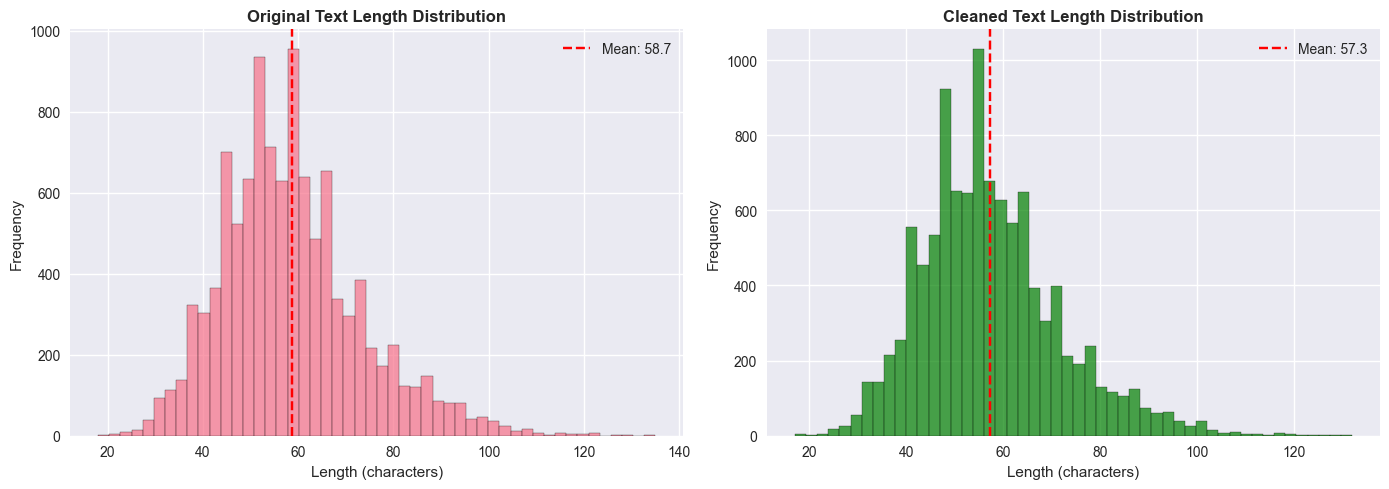


Mean original length: 58.70 characters
Mean cleaned length: 57.27 characters


In [3]:
# Preprocess text
print("Preprocessing text...")
df['cleaned_text'] = preprocess_batch(df['text'])

# Remove empty texts
df = df[df['cleaned_text'].str.len() > 0]
print(f"✓ After preprocessing: {len(df)} samples")

# Show preprocessing examples
print("\n" + "="*60)
print("Preprocessing Examples:")
print("="*60)
sample_df = df.head(5)[['text', 'cleaned_text']]
for idx, row in sample_df.iterrows():
    print(f"\nOriginal:  {row['text']}")
    print(f"Cleaned:   {row['cleaned_text']}")

# Analyze text lengths
df['text_length'] = df['text'].str.len()
df['cleaned_length'] = df['cleaned_text'].str.len()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(df['text_length'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Original Text Length Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Length (characters)')
axes[0].set_ylabel('Frequency')
axes[0].axvline(df['text_length'].mean(), color='red', linestyle='--', label=f'Mean: {df["text_length"].mean():.1f}')
axes[0].legend()

axes[1].hist(df['cleaned_length'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].set_title('Cleaned Text Length Distribution', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Length (characters)')
axes[1].set_ylabel('Frequency')
axes[1].axvline(df['cleaned_length'].mean(), color='red', linestyle='--', label=f'Mean: {df["cleaned_length"].mean():.1f}')
axes[1].legend()

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'text_length_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\nMean original length: {df['text_length'].mean():.2f} characters")
print(f"Mean cleaned length: {df['cleaned_length'].mean():.2f} characters")


## 3. Train Model


In [4]:
# Prepare data
X = df['cleaned_text'].values
y = df['label'].values

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

print(f"Train set: {len(X_train)} samples ({len(X_train)/len(df)*100:.1f}%)")
print(f"Test set: {len(X_test)} samples ({len(X_test)/len(df)*100:.1f}%)")

# Build model
print("\nBuilding model...")
model = build_model(max_features=MAX_FEATURES, ngram_range=(1, 2))
print("✓ Model built")

# Train model
print("Training model...")
model.fit(X_train, y_train)
print("✓ Training completed!")

# Save model
os.makedirs(RESULTS_DIR, exist_ok=True)
joblib.dump(model, MODEL_PATH)
print(f"✓ Model saved to {MODEL_PATH}")

# Quick evaluation on test set
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')

print(f"\nTest Set Performance:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  F1-Score (macro): {f1_macro:.4f}")


Train set: 8602 samples (80.0%)
Test set: 2151 samples (20.0%)

Building model...
✓ Model built
Training model...
✓ Training completed!
✓ Model saved to /Users/algernon/5100Project/financial-sentiment-project/results/model.joblib

Test Set Performance:
  Accuracy: 0.7792
  F1-Score (macro): 0.7750


## 4. Evaluate Model


Classification Report:
              precision    recall  f1-score   support

    negative       0.83      0.68      0.75       625
     neutral       0.77      0.78      0.78       703
    positive       0.76      0.85      0.80       823

    accuracy                           0.78      2151
   macro avg       0.79      0.77      0.78      2151
weighted avg       0.78      0.78      0.78      2151



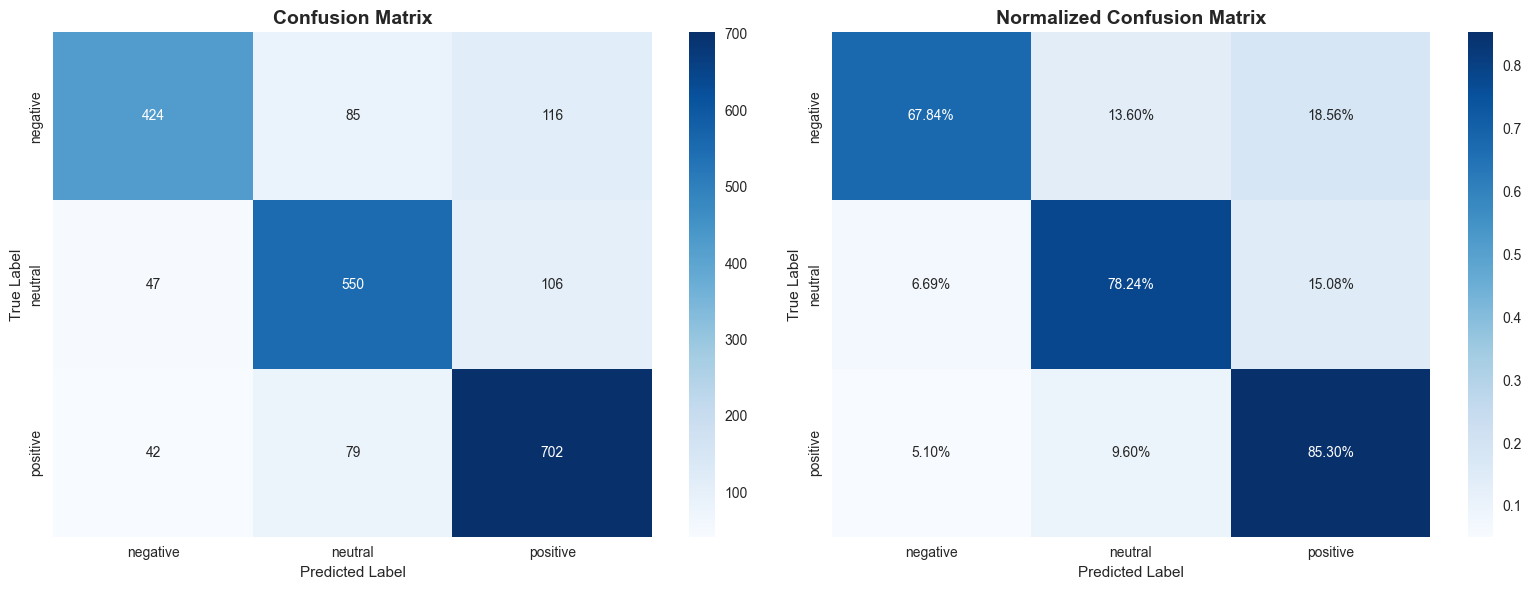


Per-Class Metrics:
          Precision    Recall  F1-Score  Support
negative   0.826511  0.678400  0.745167      625
neutral    0.770308  0.782361  0.776288      703
positive   0.759740  0.852977  0.803663      823

✓ Detailed results saved to /Users/algernon/5100Project/financial-sentiment-project/results/evaluation_results.csv


In [5]:
# Make predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)
classes = model.named_steps['classifier'].classes_

# Classification report
print("Classification Report:")
print("="*60)
print(classification_report(y_test, y_pred, target_names=classes))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Confusion matrix heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes, ax=axes[0])
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=classes, yticklabels=classes, ax=axes[1])
axes[1].set_title('Normalized Confusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

# Per-class metrics
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, labels=classes)

metrics_df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
}, index=classes)

print("\nPer-Class Metrics:")
print("="*60)
print(metrics_df)

# Save evaluation results
results_df = pd.DataFrame({
    'text': [df.iloc[i]['text'] for i in range(len(X_test))],
    'cleaned_text': X_test,
    'true_label': y_test,
    'predicted_label': y_pred,
    'confidence': np.max(y_proba, axis=1)
})

for i, class_name in enumerate(classes):
    results_df[f'prob_{class_name}'] = y_proba[:, i]

results_df.to_csv(os.path.join(RESULTS_DIR, 'evaluation_results.csv'), index=False)
print(f"\n✓ Detailed results saved to {RESULTS_DIR}/evaluation_results.csv")


## 5. Top Features Analysis


Top Features by Class:

NEGATIVE:
  falls                       4.6867
  fall                        4.4797
  slips                       4.4325
  sell                        3.6180
  low                         3.3440
  weak                        3.0617
  lower                       2.9748
  drops                       2.9483
  dips                        2.8334
  plunges                     2.8314

NEUTRAL:
  sebi                        3.1473
  appoints                    3.0087
  profit rs                   2.8029
  steady                      2.6157
  ipo                         2.5529
  mixed                       2.3924
  ceo                         2.1203
  director                    2.0612
  flat                        2.0279
  range                       2.0062

POSITIVE:
  surges                      4.0283
  rallies                     3.8262
  rises                       3.7803
  high                        3.5006
  gain                        3.3562
  gains             

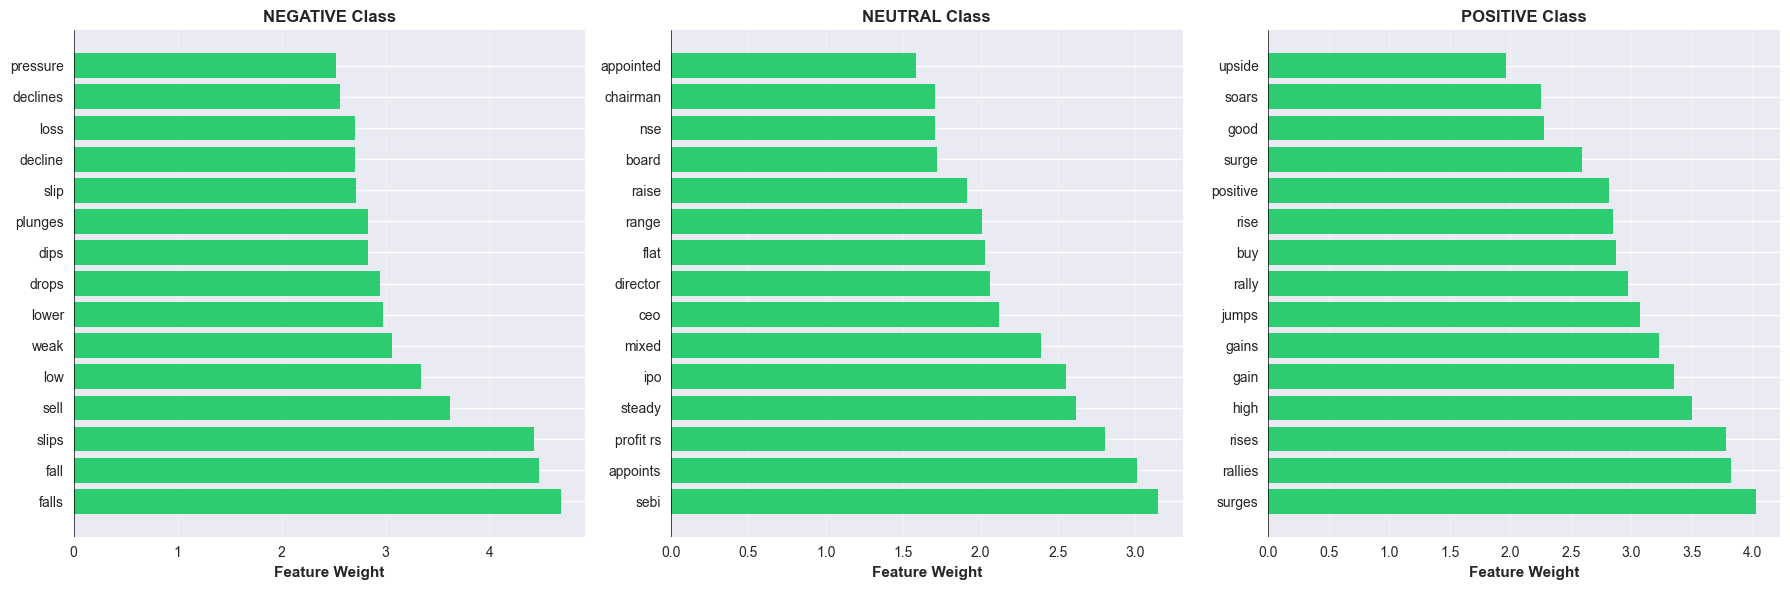

In [6]:
# Get top features for each class
top_features = get_all_top_features(model, top_n=20)

print("Top Features by Class:")
print("="*60)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (class_name, features) in enumerate(top_features.items()):
    # Extract feature names and weights
    feature_names = [f[0] for f in features[:15]]  # Top 15
    weights = [f[1] for f in features[:15]]
    
    # Plot
    colors = ['#2ecc71' if w > 0 else '#e74c3c' for w in weights]
    axes[idx].barh(range(len(feature_names)), weights, color=colors)
    axes[idx].set_yticks(range(len(feature_names)))
    axes[idx].set_yticklabels(feature_names)
    axes[idx].set_xlabel('Feature Weight', fontweight='bold')
    axes[idx].set_title(f'{class_name.upper()} Class', fontsize=12, fontweight='bold')
    axes[idx].axvline(0, color='black', linestyle='-', linewidth=0.5)
    axes[idx].grid(axis='x', alpha=0.3)
    
    # Print to console
    print(f"\n{class_name.upper()}:")
    for feature, weight in features[:10]:
        print(f"  {feature:25s} {weight:8.4f}")

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'top_features.png'), dpi=300, bbox_inches='tight')
plt.show()


## 6. Label Quality Analysis


Running label quality analysis...

1. Detecting misclassifications...
Found 1323 misclassifications
Saved to /Users/algernon/5100Project/financial-sentiment-project/results/misclassifications.csv

2. Detecting ambiguous predictions...
Found 1860 ambiguous predictions (confidence between 0.45 and 0.55)
Saved to /Users/algernon/5100Project/financial-sentiment-project/results/ambiguous_predictions.csv

3. Detecting noisy labels...
Found 1299 potentially noisy labels
Saved to /Users/algernon/5100Project/financial-sentiment-project/results/noisy_labels.csv

Label Quality Summary:
Total misclassifications: 1323 (12.30%)
Ambiguous predictions: 1860 (17.30%)
Potentially noisy labels: 1299 (12.08%)


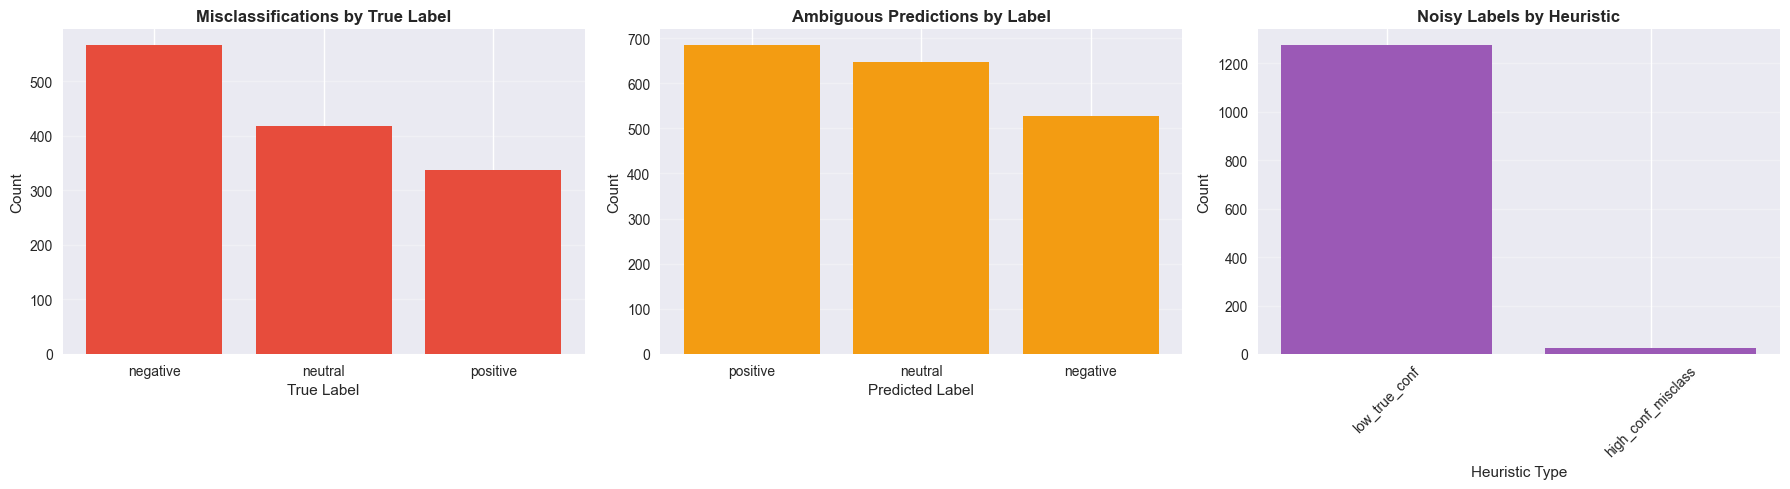


Sample Misclassifications:

True: neutral | Predicted: negative | Confidence: 0.416
Text: MMTC Q2 net loss at Rs 10.4 crore...

True: neutral | Predicted: positive | Confidence: 0.652
Text: Infosys: Will the strong volume growth sustain?...

True: negative | Predicted: neutral | Confidence: 0.445
Text: Why Chinese stocks leave US investors vulnerable...

True: neutral | Predicted: positive | Confidence: 0.411
Text: ZEE Q2 net at Rs 216.3 cr...

True: neutral | Predicted: positive | Confidence: 0.467
Text: Yen firms in Asia on Iraq, Ukraine jitters...


In [7]:
# Run label quality analysis
print("Running label quality analysis...")
print("="*60)

# 1. Misclassifications
print("\n1. Detecting misclassifications...")
misclass_df = detect_misclassifications(
    MODEL_PATH, DATA_PATH, DATASET_NAME,
    os.path.join(RESULTS_DIR, 'misclassifications.csv')
)

# 2. Ambiguous predictions
print("\n2. Detecting ambiguous predictions...")
ambiguous_df = detect_ambiguous_predictions(
    MODEL_PATH, DATA_PATH, DATASET_NAME,
    confidence_threshold=(0.45, 0.55),
    output_path=os.path.join(RESULTS_DIR, 'ambiguous_predictions.csv')
)

# 3. Noisy labels
print("\n3. Detecting noisy labels...")
noisy_df = detect_noisy_labels(
    MODEL_PATH, DATA_PATH, DATASET_NAME,
    output_path=os.path.join(RESULTS_DIR, 'noisy_labels.csv')
)

# Summary
print("\n" + "="*60)
print("Label Quality Summary:")
print("="*60)
print(f"Total misclassifications: {len(misclass_df)} ({len(misclass_df)/len(df)*100:.2f}%)")
print(f"Ambiguous predictions: {len(ambiguous_df)} ({len(ambiguous_df)/len(df)*100:.2f}%)")
print(f"Potentially noisy labels: {len(noisy_df)} ({len(noisy_df)/len(df)*100:.2f}%)")

# Visualize label quality metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Misclassifications by true label
if len(misclass_df) > 0:
    misclass_by_label = misclass_df['true_label'].value_counts()
    axes[0].bar(misclass_by_label.index, misclass_by_label.values, color='#e74c3c')
    axes[0].set_title('Misclassifications by True Label', fontweight='bold')
    axes[0].set_xlabel('True Label')
    axes[0].set_ylabel('Count')
    axes[0].grid(axis='y', alpha=0.3)

# Ambiguous predictions by predicted label
if len(ambiguous_df) > 0:
    ambiguous_by_label = ambiguous_df['predicted_label'].value_counts()
    axes[1].bar(ambiguous_by_label.index, ambiguous_by_label.values, color='#f39c12')
    axes[1].set_title('Ambiguous Predictions by Label', fontweight='bold')
    axes[1].set_xlabel('Predicted Label')
    axes[1].set_ylabel('Count')
    axes[1].grid(axis='y', alpha=0.3)

# Noisy labels by heuristic
if len(noisy_df) > 0:
    noisy_by_heuristic = noisy_df['heuristic'].value_counts()
    axes[2].bar(noisy_by_heuristic.index, noisy_by_heuristic.values, color='#9b59b6')
    axes[2].set_title('Noisy Labels by Heuristic', fontweight='bold')
    axes[2].set_xlabel('Heuristic Type')
    axes[2].set_ylabel('Count')
    axes[2].tick_params(axis='x', rotation=45)
    axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'label_quality_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

# Show sample misclassifications
if len(misclass_df) > 0:
    print("\n" + "="*60)
    print("Sample Misclassifications:")
    print("="*60)
    for idx, row in misclass_df.head(5).iterrows():
        print(f"\nTrue: {row['true_label']} | Predicted: {row['predicted_label']} | Confidence: {row['confidence']:.3f}")
        print(f"Text: {row['text'][:100]}...")


In [8]:
# Final summary
print("="*60)
print("PIPELINE COMPLETE - RESULTS SUMMARY")
print("="*60)
print(f"\nDataset: {DATASET_NAME}")
print(f"Total samples: {len(df)}")
print(f"Train samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"\nModel Performance:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  F1-Score (macro): {f1_macro:.4f}")
print(f"\nLabel Quality:")
print(f"  Misclassifications: {len(misclass_df)}")
print(f"  Ambiguous predictions: {len(ambiguous_df)}")
print(f"  Noisy labels: {len(noisy_df)}")
print(f"\nAll results saved to: {RESULTS_DIR}/")
print("\n✓ Pipeline completed successfully!")


PIPELINE COMPLETE - RESULTS SUMMARY

Dataset: sentfin
Total samples: 10753
Train samples: 8602
Test samples: 2151

Model Performance:
  Accuracy: 0.7792
  F1-Score (macro): 0.7750

Label Quality:
  Misclassifications: 1323
  Ambiguous predictions: 1860
  Noisy labels: 1299

All results saved to: /Users/algernon/5100Project/financial-sentiment-project/results/

✓ Pipeline completed successfully!
